# **Multiclass Classification of X-ray Radiographs with Transfer Learning (DenseNet-169)**

This notebook serves as a self-educational project in which knowledge derived from other projects and documentation from the TensorFlow guidelines is applied to a multiclass classification task of X-ray images.

This only features the initialisation and fine-tuning of a toy `DenseNet-169` pretrained model. This is to validate each component in the pipeline, i.e., **model initialisation**, **training**, **prediction**, and **corresponding functions**. Once validated, these code components are modularised. 

The experimentation will be tracked with the Weights and Biases (wandb) platform.

### Required Libraries

In [15]:
import os
import matplotlib.pyplot as plt                # Visualise images

import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"       # Supress TF messages

import numpy as np

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("TensorFlow version : ", tf.__version__)  # Check TF version

# Check TensorFlow is using the GPU -- for local machine:
gpu = tf.config.list_physical_devices("GPU")

try:
   tf.config.experimental.set_memory_growth(gpu[0], True)
except:
    # Memory growth must be set before GPUs have been initialized
    print("GPU runtime already initialised.")

# Enable memory growth:
# tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version :  2.10.1


### WandB Installation, Login, and Initialisation

In [ ]:
# For Colab environment:
# !pip install wandb

In [4]:
config = dict(
    learning_rate = 0.0001,
    architecture = "DENSENET-169",
    dataset      = "Chest X-Ray Images (Pneumonia)",
    class_names  = ["normal", "bacteria", "virus"],
    num_classes  = 3,
    val_split    = 0.2,
    init_epochs  = 10,  # initial epochs
    fine_epochs  = 30,  # fine-tuning epochs
    batch_size   = 32,
    image_size   = (300, 300),
    dropout_rate = 0.2,
    activation   = "softmax"
)

In [77]:
%env "WANDB_NOTEBOOK_NAME" "PCXR-transfer-learning-with-densenet-169"
import wandb

# Start wandb run and instantiate project
wandb.init(
    project="PCXR-project", 
    name="custom-logger-test",
    notes="testing custom metrics through callback",
    config=config
)

env: "WANDB_NOTEBOOK_NAME"="PCXR-transfer-learning-with-densenet-169"


In [6]:
# Convert ipynb notebook to html
# NB_NAME = "PCXR-transfer-learning-with-densenet-169.ipynb"
# NB_DIR = "..\\notebooks"
# CURR_NB = os.path.join(NB_DIR, NB_NAME)

# print("Converting", NB_NAME, "to HTML.")

# %pip install nbconvert
# %jupyter nbconvert --to html CURR_NB

### Data Loading

Here, the data is loaded into the environment with the `image_dataset_from_directory` function, which yields batches of images in the form of `tf.data.Dataset`. For this project, the batch size is configured to 32 images, while the dimensions of each image is configured to a (300, 300) shape. Finally, a validation split of 0.2 is configured for the validation set.

The total number of images per class is also computed below, to check for class imbalance. There is a 2:1:1 ratio spread between the classes, which is a relatively balanced dataset. This is important as it determines which evaluation metrics should be implemented to more accurately reflect model performance.

In [38]:
# Configure directories -- for local machine:
TRAIN_DIR = "..\\artifacts\\train"
TEST_DIR = "..\\artifacts\\test"

# Configure directories -- for Colab environment:
# TRAIN_DIR = os.path.join(PROJECT_ROOT, "images/train")
# TEST_DIR = os.path.join(PROJECT_ROOT, "images/test")

# Load in datasets:
print("LOAD : training and validation data set")
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    label_mode="int",
    class_names=config["class_names"],
    batch_size=None,
    image_size=config["image_size"],
    shuffle=True,
    seed=42,
    validation_split=config["val_split"],
    subset="both")

print("LOAD : testing data set")
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    label_mode="int",
    class_names=config["class_names"],
    batch_size=None,
    image_size=config["image_size"],
    shuffle=True,
    seed=42,
    subset=None)

LOAD : training and validation data set
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
LOAD : testing data set
Found 1172 files belonging to 3 classes.


In [39]:
# Check number of each class of images
for dir in (TRAIN_DIR, TEST_DIR):
    print("In :", dir)
    for pattern in config["class_names"]:
      subdir = os.path.join(dir, pattern)
      print("Number of", pattern, "images:",
            len([entry for entry in os.listdir(subdir)
            if os.path.isfile(os.path.join(subdir, entry))]))

In : ..\artifacts\train
Number of normal images: 1266
Number of bacteria images: 2224
Number of virus images: 1194
In : ..\artifacts\test
Number of normal images: 317
Number of bacteria images: 556
Number of virus images: 299


### Data Exploration

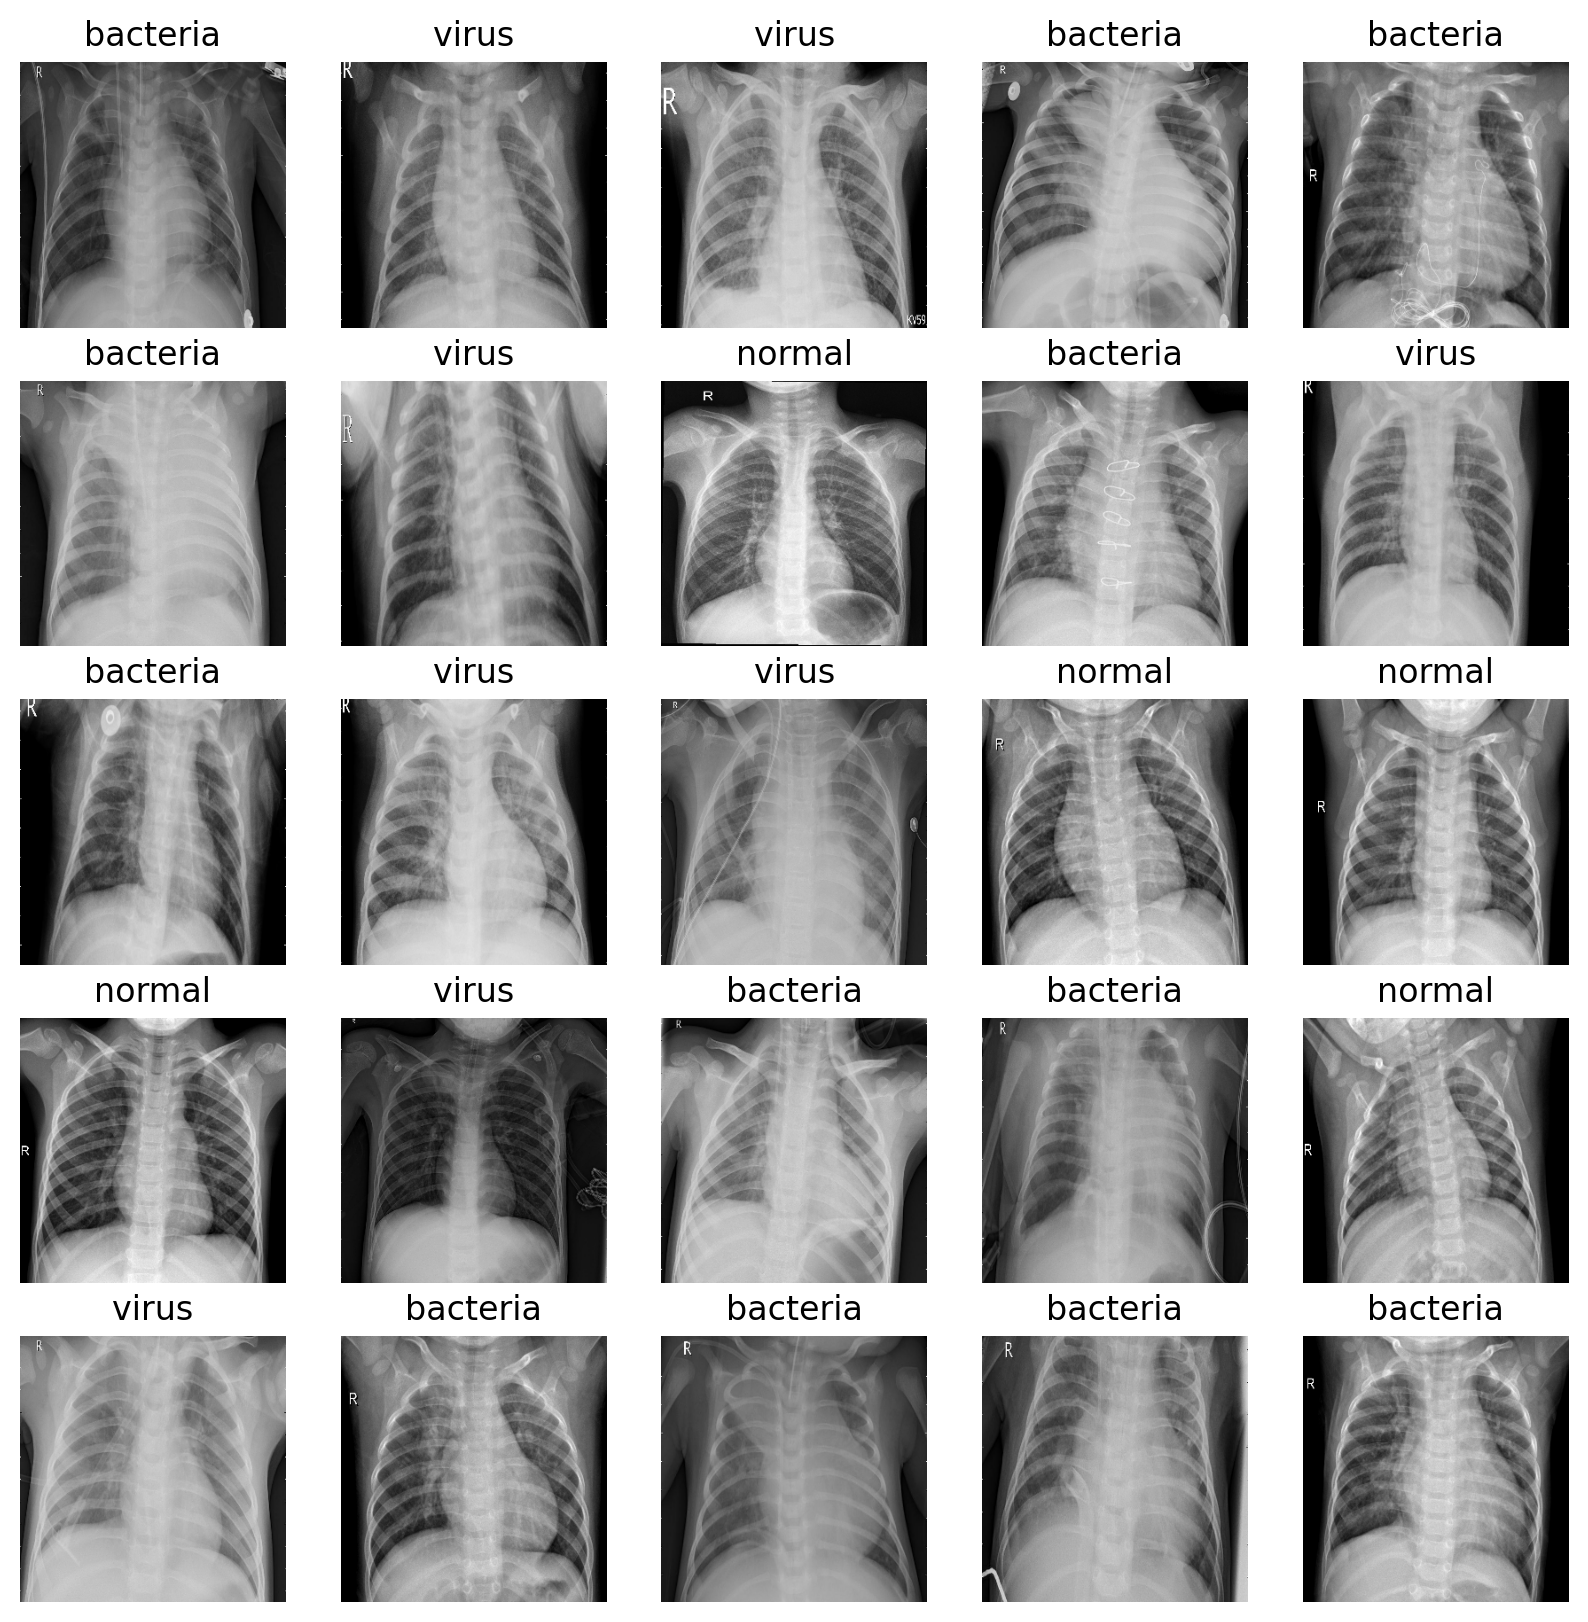

In [7]:
# Configure retina backend for clearer images
%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(config["class_names"][labels[i]])
        plt.axis("off")

In [8]:
# Count number of batches for training and validation sets
train_batches = tf.data.experimental.cardinality(train_ds)
valid_batches = tf.data.experimental.cardinality(valid_ds)

print("Number of training batches   : %d" % train_batches)
print("Number of validation batches : %d" % valid_batches)

Number of training batches   : 118
Number of validation batches : 30


### Dataset Configuration for Performance (with prefetching)

Prefetching is configured for both training and validation sets. This overlaps the preprocessing and model execution component in the training phase. During training step `T`, the pipeline is already "prefetching" the next round of data for the subsequent step `T + 1`. This reduces the duration to extract the data during the entire training phase.

The internal buffer, which determines the number of elements to prefetch ahead of when they are requested, is configured to `tf.data.AUTOTUNE`, which prompts the `tf.data` runtime to dynamically tune the value.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [8]:
# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

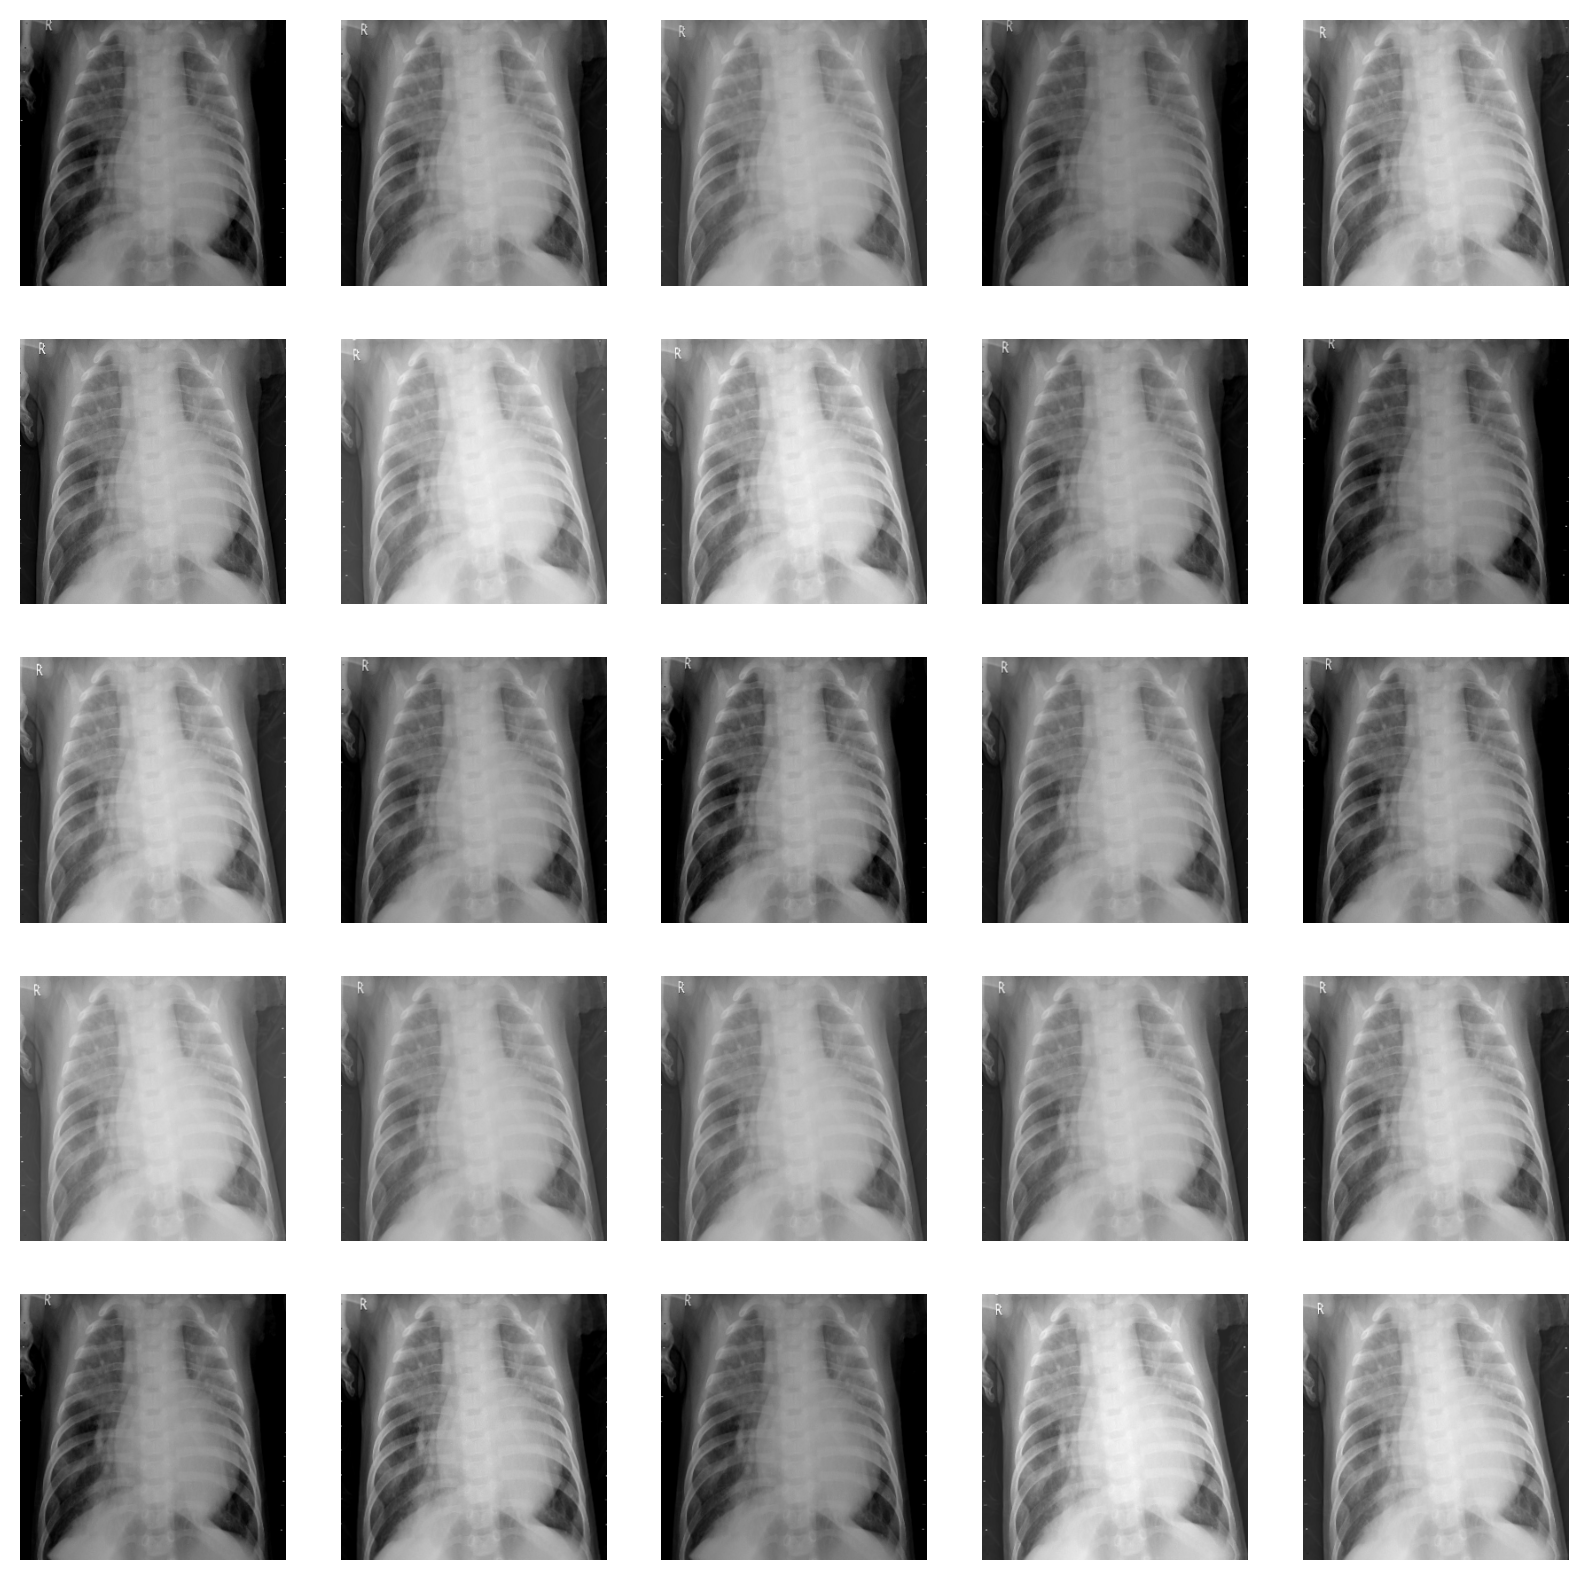

In [17]:
# Check augmented results
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

for img, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_img = img[0]

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    aug_img = augment_layer(tf.expand_dims(first_img, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

### Model Building (with functional API)

In [9]:
# Configure image shape for model input shape
IMG_SHAPE = config["image_size"] + (3,)

# Instantiate base model
base_model = tf.keras.applications.densenet.DenseNet169(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
base_model.trainable = False

# Instantiate DenseNet preprocessing method
preprocess_input = tf.keras.applications.densenet.preprocess_input

# Check model-extracted feature shape:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print("Output shape following feature extraction:")
print(image_batch.shape, "-->", feature_batch.shape)

# converts each (160, 160, 3) image to a (9, 9, 1664) block of features

Output shape following feature extraction:
(32, 300, 300, 3) --> (32, 9, 9, 1664)


In [40]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

# Establish baseline model:
x = augment_layer(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
x = tf.keras.layers.MaxPooling2D(input_shape=(1664,))(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Prevent overfitting
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(config["num_classes"], activation=config["activation"])(x)

# Instantiate model:
model = tf.keras.Model(inputs, outputs)

# Check network architecture:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                           

### Custom Logging Callback

In [16]:
# Separate validation data to data and labels for custom metric computation
x_val = np.concatenate([x for x, y in valid_ds], axis=0)
y_val = np.concatenate([y for x, y in valid_ds], axis=0)

In [32]:
# Create callback to log MCC and F1 scores and log them in WandB:
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef


# Configure custom log callback:
class CustomLogCallbackWB(tf.keras.callbacks.Callback):
    def __init__(self, model, x_val, y_val):
        super().__init__()
        self.model = model
        self.x_val = x_val
        self.y_val = y_val

        # Instantiate standalone metrics:
        self._mcc = tf.keras.metrics.Mean(name="mcc")
        self._f1score = tf.keras.metrics.Mean(name="f1_score")
        self._aucroc = tf.keras.metrics.AUC(name="auc_roc")

        self.epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

        self._mcc.reset_state()
        self._f1score.reset_state()
        self._aucroc.reset_state()

        print("Generating predictions and computing metrics for Epoch {} ".format(self.epoch))
        predictions = self.model.predict(self.x_val)

        f1score = f1_score(self.y_val, np.argmax(predictions, axis=-1),
                            average=None)
        mcc = matthews_corrcoef(self.y_val, np.argmax(predictions, axis=-1))

        self._mcc.update_state(mcc)
        self._f1score.update_state(f1score)
        self._aucroc.update_state(self.y_val, np.argmax(predictions, axis=-1))

        print("training loss : {} , training acc : {} , mcc score : {}".format(
            logs["loss"], logs["accuracy"], self._mcc.result().numpy()
        ))
        print("aucroc score  : {} , f1 score     : {} ".format(
            self._aucroc.result().numpy(), self._f1score.result().numpy()
        ))

        # Log metrics to WandB:
        wandb.log({"mcc": self._mcc.result().numpy(),
                   "fmeasure": self._f1score.result().numpy(),
                   "auc_roc": self._aucroc.result().numpy()})

## Model Compilation

Since the data is not strongly imbalanced, the accuracy score can be used as an evaluation metric.

In [43]:
# Compile the augmented model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

## **Model Training Phase**

The model is evaluated initially against the validation dataset to test its effectiveness without training. Unsurprisingly, the model performs poorly. Therefore, the model was trained for ten epochs and evaluated based on the validation accuracy score, which increases gradually through each epoch, indicating that the model is effectively learning from the training images. For better visualisation, learning curves are plotted.

In [91]:
# Evaluate model on validation set without training
eval_loss, eval_accuracy = model.evaluate(valid_ds)

print("initial loss     : {:.2f}".format(eval_loss))
print("initial accuracy : {:.2f}".format(eval_accuracy))

30/30 [==============================] - 6s 85ms/step - loss: 0.9744 - accuracy: 0.5128
initial loss     : 0.97
initial accuracy : 0.51


In [44]:
# Configure callback:
# custom_log_callback = [CustomLogCallbackWB(model, x_val, y_val)]
# wanbd_metrics_callback = [wandb.keras.WandbMetricsLogger()]

# callbacks = custom_log_callback + wanbd_metrics_callback

# Train model:
model.fit(
    train_ds,
    epochs=config["init_epochs"],
    validation_data=valid_ds,
    verbose=2,
    batch_size=config["batch_size"]
)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\Projects\pneumonia-xray-classification\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 300, 300, 3), found shape=(300, 300, 3)


In [93]:
# Close WandB run:
wandb.finish()

epoch/accuracy,▁▄▅▇▇▇████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁
epoch/val_accuracy,▁▅▆▆▇▇▇███
epoch/val_loss,█▅▄▃▂▂▂▂▁▁
fmeasure,▁▅▆▆▆▇▇███
mcc,▁▅▆▆▆▇▇███
epoch/accuracy,0.76361
epoch/epoch,9
epoch/learning_rate,0.0001


## **Fine-tuning Phase**

Here, the layers are unfrozen. Only a portion of the model will be configured to trainable. Since the training set is not a large dataset, a smaller number of parameters (only layers after the 500th layer) were unfrozen, to prevent overfitting. Then, the model was compiled with the RMSprop optimiser, which is implemented for its quick convergence times.

In [ ]:
# Unfreeze top layers of model
base_model.trainable = True

# Check base model layers
print("Number of layers in base model:", len(base_model.layers))

In [ ]:
# Freeze all layers before 500 layers
fine_tune_at = 500

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=config["learning_rate"]/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()

Number of layers in base model: 595


In [ ]:
total_epochs = config["init_epochs"] + config["fine_epochs"]

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=False)

history_tuned = model.fit(train_ds,
                          epochs=total_epochs,
                          initial_epoch=config["init_epochs"],
                          validation_data=valid_ds,
                          callbacks=es_callback,
                          verbose=1)